In [2]:
from prettytable import PrettyTable
import numpy as np
import scipy.stats
from sklearn.metrics import mean_squared_error, r2_score
import emukit.examples.multi_fidelity_dgp

from emukit.examples.multi_fidelity_dgp.baseline_model_wrappers import LinearAutoRegressiveModel, NonLinearAutoRegressiveModel, HighFidelityGp

from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign
from emukit.examples.multi_fidelity_dgp.multi_fidelity_deep_gp import MultiFidelityDeepGP

from emukit.test_functions.multi_fidelity import (multi_fidelity_borehole_function, multi_fidelity_branin_function,
                                                  multi_fidelity_park_function, multi_fidelity_hartmann_3d,
                                                  multi_fidelity_currin_function)

AttributeError: module 'tensorflow' has no attribute 'Session'

In [3]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])

borehole = Function(name='borehole', y_scale=100, noise_level=[0.05, 0.1], do_x_scaling=True, num_data=[60, 5], 
                    fcn=multi_fidelity_borehole_function)
branin = Function(name='branin', y_scale=1, noise_level=[0., 0., 0.], do_x_scaling=False, num_data=[80, 30, 10], 
                    fcn=multi_fidelity_branin_function)
currin = Function(name='currin', y_scale=1, noise_level=[0., 0.], do_x_scaling=False, num_data=[12, 5], 
                    fcn=multi_fidelity_currin_function)
park = Function(name='park', y_scale=1, noise_level=[0., 0.], do_x_scaling=False, num_data=[30, 5], 
                    fcn=multi_fidelity_park_function)
hartmann_3d = Function(name='hartmann', y_scale=100, noise_level=[0., 0., 0.], do_x_scaling=False, num_data=[80, 40, 20], 
                    fcn=multi_fidelity_hartmann_3d)

In [4]:
# Function to repeat test across different random seeds.

def do_benchmark(fcn_tuple):
    metrics = dict()

    # Some random seeds to use
    seeds = [123, 184, 202, 289, 732]

    for i, seed in enumerate(seeds):
        run_name = str(seed) + str(fcn_tuple.num_data)
        metrics[run_name] = test_function(fcn_tuple, seed)
        print('After ' + str(i+1) + ' runs of ' + fcn_tuple.name)
        print_metrics(metrics)

    return metrics

In [5]:
# Print metrics as table 
def print_metrics(metrics):
    model_names = list(list(metrics.values())[0].keys())
    metric_names = ['r2', 'mnll', 'rmse']
    table = PrettyTable(['model'] + metric_names)

    for name in model_names:
        mean = []
        for metric_name in metric_names:
            mean.append(np.mean([metric[name][metric_name] for metric in metrics.values()]))
        table.add_row([name] + mean)

    print(table)


In [6]:
def test_function(fcn, seed):
    np.random.seed(seed)

    x_test, y_test, X, Y = generate_data(fcn, 1000)

    mf_dgp_fix_lf_mean = MultiFidelityDeepGP(X, Y, n_iter=5000)
    mf_dgp_fix_lf_mean.name = 'mf_dgp_fix_lf_mean'

    models = [HighFidelityGp(X, Y), LinearAutoRegressiveModel(X, Y), NonLinearAutoRegressiveModel(X, Y), mf_dgp_fix_lf_mean]
    return benchmark_models(models, x_test, y_test)

In [7]:
def benchmark_models(models, x_test, y_test):
    metrics = dict()
    for model in models:
        model.optimize()
        y_mean, y_var = model.predict(x_test)
        metrics[model.name] = calculate_metrics(y_test, y_mean, y_var)
        print('+ ######################## +')
        print(model.name, 'r2', metrics[model.name]['r2'])
        print('+ ######################## + ')
    return metrics

In [8]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [9]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [10]:
metrics = []
metrics.append(do_benchmark(currin))

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


(5, 2)
Optimization restart 1/10, f = 7.06968081801714
Optimization restart 2/10, f = 7.06968052426023
Optimization restart 3/10, f = 7.069687061060952
Optimization restart 4/10, f = 7.069680483852824
Optimization restart 5/10, f = 7.06968048182017
Optimization restart 6/10, f = 7.069680523781146
Optimization restart 7/10, f = 7.069680483606621
Optimization restart 8/10, f = 7.069681680418789
Optimization restart 9/10, f = 7.069680526114141
Optimization restart 10/10, f = 7.069685192138575
+ ######################## +
hf_gp r2 0.9011811180408466
+ ######################## + 
Optimization restart 1/10, f = 15.352114015391281
Optimization restart 2/10, f = 15.326188049778139
Optimization restart 3/10, f = 15.326188047773647
Optimization restart 4/10, f = 15.352126107046747
Optimization restart 5/10, f = 15.326188074655077
Optimization restart 6/10, f = 15.352113990966592
Optimization restart 7/10, f = 15.326188599421315
Optimization restart 8/10, f = 15.326188390789717
Optimization resta

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


Optimization restart 1/10, f = 5.08654552345217
Optimization restart 2/10, f = 5.086545442235973
Optimization restart 3/10, f = 5.086545792784737
Optimization restart 4/10, f = 5.086561510655844
Optimization restart 5/10, f = 5.086559853054927
Optimization restart 6/10, f = 5.086545638446346
Optimization restart 7/10, f = 5.086546853705133
Optimization restart 8/10, f = 6.812700792636314
Optimization restart 9/10, f = 5.086545582505135
Optimization restart 10/10, f = 5.086567086116215
+ ######################## +
hf_gp r2 0.8451932929837366
+ ######################## + 
Optimization restart 1/10, f = 21.869991964665836
Optimization restart 2/10, f = 21.869992921173797
Optimization restart 3/10, f = 21.869992167204245
Optimization restart 4/10, f = 21.869991997857667
Optimization restart 5/10, f = 21.869992014726442
Optimization restart 6/10, f = 21.869991927637727
Optimization restart 7/10, f = 21.869991983884233
Optimization restart 8/10, f = 21.86999191021931
Optimization restart 9/1

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 3.3397353320619145
Optimization restart 2/10, f = 2.9295861039276216


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/10, f = 2.868074457359783
Optimization restart 4/10, f = 5.08654597983559
Optimization restart 5/10, f = 5.086545920350248
Optimization restart 6/10, f = 2.8676097135249363


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide


Optimization restart 7/10, f = 3.874652242019547


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 8/10 failed
Optimization restart 9/10, f = 2.9295904505330146
Optimization restart 10/10, f = 2.8676090021301244
+ ######################## +
nargp r2 0.9014670146792917
+ ######################## + 
+ ######################## +
mf_dgp_fix_lf_mean r2 0.9198744068274834
+ ######################## + 
After 2 runs of currin
+--------------------+--------------------+--------------------+--------------------+
|       model        |         r2         |        mnll        |        rmse        |
+--------------------+--------------------+--------------------+--------------------+
|       hf_gp        | 0.8731872055122916 | 143.59634320730433 | 0.8545883294908618 |
|        ar1         | 0.8808126564181925 | 145.3790886805661  | 0.8307972021729757 |
|       nargp        | 0.9009729299446518 | 317.62985761618677 | 0.7598672513959941 |
| mf_dgp_fix_lf_mean | 0.9274630885509412 | 0.9584918149038268 | 0.6494550163822708 |
+--------------------+--------------------+-

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


Optimization restart 1/10, f = 9.49401227550679
Optimization restart 2/10, f = 8.71948305887514
Optimization restart 3/10, f = 8.719494995877758
Optimization restart 4/10, f = 8.719483000671508
Optimization restart 5/10, f = 8.719482929592289
Optimization restart 6/10, f = 8.71948293201519
Optimization restart 7/10, f = 8.719483047726897
Optimization restart 8/10, f = 8.719483225796278
Optimization restart 9/10, f = 8.71948294213508
Optimization restart 10/10, f = 8.719482916762832
+ ######################## +
hf_gp r2 0.8744404940641421
+ ######################## + 
Optimization restart 1/10, f = 16.04577555439677
Optimization restart 2/10, f = 16.045774821635423
Optimization restart 3/10, f = 16.04577593194273
Optimization restart 4/10, f = 16.04578021386359
Optimization restart 5/10, f = 16.04577503228662
Optimization restart 6/10, f = 16.04577702860745
Optimization restart 7/10, f = 16.045775721343546
Optimization restart 8/10, f = 16.04577499745153
Optimization restart 9/10, f = 1

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/10, f = 23.22743008036113
Optimization restart 3/10, f = 23.227429898153975
Optimization restart 4/10, f = 23.22742989002616
Optimization restart 5/10, f = 23.22742991556616
Optimization restart 6/10, f = 23.227430587843223
Optimization restart 7/10, f = 23.227429949244573
Optimization restart 8/10, f = 41.222125480019834
Optimization restart 9/10, f = 23.227429869001945
Optimization restart 10/10, f = 23.227429955759483
+ ######################## +
ar1 r2 0.9799454375842065
+ ######################## + 
Optimization restart 1/10, f = 20.326652568327653
Optimization restart 2/10, f = 20.32665256969644
Optimization restart 3/10, f = 20.326652568325606
Optimization restart 4/10, f = 20.32665262159675
Optimization restart 5/10, f = 20.326652568336
Optimization restart 6/10, f = 20.326652569398245
Optimization restart 7/10, f = 20.32665256838129
Optimization restart 8/10, f = 20.326652568426866
Optimization restart 9/10, f = 20.32665256921201
Optimization restart 10/

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/10, f = 0.35734871837791005
Optimization restart 4/10, f = 0.35734574588392576
Optimization restart 5/10, f = 0.3573457897628183


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 6/10, f = 2.6626701180190793
Optimization restart 7/10, f = 0.3573463096944396
Optimization restart 8/10, f = 0.3573520956619989
Optimization restart 9/10, f = 0.35734565698023424
Optimization restart 10/10, f = 0.3573483545887779
+ ######################## +
nargp r2 0.9647837420886455
+ ######################## + 
+ ######################## +
mf_dgp_fix_lf_mean r2 0.9721231920039944
+ ######################## + 
After 3 runs of currin
+--------------------+--------------------+--------------------+--------------------+
|       model        |         r2         |        mnll        |        rmse        |
+--------------------+--------------------+--------------------+--------------------+
|       hf_gp        | 0.8736049683629084 | 96.31003686260387  | 0.8538386084171142 |
|        ar1         | 0.9138569168068639 | 98.20591851256175  | 0.667411101393567  |
|       nargp        | 0.9222432006593163 | 213.67559741816078 | 0.6570440354980621 |
| mf_dgp_fix_lf_mean |

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


Optimization restart 1/10, f = 7.069680817946232
Optimization restart 2/10, f = 7.069680510549437
Optimization restart 3/10, f = 7.069680495284549
Optimization restart 4/10, f = 7.06968059369167
Optimization restart 5/10, f = 7.069680483328575
Optimization restart 6/10, f = 7.06968048269385
Optimization restart 7/10, f = 7.069699715624772
Optimization restart 8/10, f = 7.0696804818139665


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 9/10, f = 8.141173015256596
Optimization restart 10/10, f = 7.069680481977157
+ ######################## +
hf_gp r2 0.8925925058169994
+ ######################## + 
Optimization restart 1/10, f = 10.924513199070482
Optimization restart 2/10, f = 10.924528722701229
Optimization restart 3/10, f = 10.924554796000896
Optimization restart 4/10, f = 10.924517530446192
Optimization restart 5/10, f = 10.924513285443199


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 6/10, f = 14.069592647769966
Optimization restart 7/10, f = 10.924513145923527
Optimization restart 8/10, f = 10.924515238333651
Optimization restart 9/10, f = 16.344891360408706
Optimization restart 10/10, f = 10.924513681420105
Optimization restart 1/10, f = 10.924513145906065
Optimization restart 2/10, f = 11.671510541734964
Optimization restart 3/10, f = 11.671510530593975
Optimization restart 4/10, f = 11.671510523803857
Optimization restart 5/10, f = 17.20014723815433
Optimization restart 6/10, f = 11.671605366686117
Optimization restart 7/10, f = 11.671510515652592
Optimization restart 8/10, f = 17.200149232501985
Optimization restart 9/10, f = 11.671510607362348
Optimization restart 10/10, f = 17.210298320536268
+ ######################## +
ar1 r2 0.9145406773598186
+ ######################## + 
Optimization restart 1/10, f = 19.123744583102102
Optimization restart 2/10, f = 19.59534119165909
Optimization restart 3/10, f = 19.595341191649947
Optimization re

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


Optimization restart 1/10, f = 7.894362742979933
Optimization restart 2/10, f = 7.894362729442359
Optimization restart 3/10, f = 7.894362732344894
Optimization restart 4/10, f = 7.894362732770479
Optimization restart 5/10, f = 8.622405556093247
Optimization restart 6/10, f = 8.622406148563025
Optimization restart 7/10, f = 7.89436272901888
Optimization restart 8/10, f = 7.894363654454283
Optimization restart 9/10, f = 7.894362770557603
Optimization restart 10/10, f = 8.622405696049878
+ ######################## +
hf_gp r2 0.8321258084223342
+ ######################## + 
Optimization restart 1/10, f = 16.23198062711704
Optimization restart 2/10, f = 16.231980639344165
Optimization restart 3/10, f = 16.231980609802317
Optimization restart 4/10, f = 16.23198089375596
Optimization restart 5/10, f = 16.23198060571438
Optimization restart 6/10, f = 16.231980782976677
Optimization restart 7/10, f = 16.231981416997968
Optimization restart 8/10, f = 16.23198086049066
Optimization restart 9/10, 

In [11]:
print(currin)

Function(name='currin', y_scale=1, noise_level=[0.0, 0.0], do_x_scaling=False, num_data=[12, 5], fcn=<function multi_fidelity_currin_function at 0x1a27f09730>)


In [12]:
x_test, y_test, X, Y = generate_data(currin, 1000)

(5, 2)


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/emukit/test_functions/multi_fidelity/currin.py:34: RuntimeWarning:divide by zero encountered in true_divide


In [14]:
print(x_test.shape)

(1000, 3)


In [16]:
print(x_test[0:10,:])

[[0.0305 0.6205 1.    ]
 [0.1615 0.2875 1.    ]
 [0.4575 0.2825 1.    ]
 [0.2885 0.0685 1.    ]
 [0.5575 0.1235 1.    ]
 [0.8125 0.3515 1.    ]
 [0.5995 0.3965 1.    ]
 [0.6495 0.9105 1.    ]
 [0.2785 0.9625 1.    ]
 [0.1605 0.9115 1.    ]]


In [17]:
print(y_test[0:10,:])

[[-1.72591764]
 [-1.35428002]
 [-1.0470661 ]
 [ 0.99090367]
 [ 0.80174738]
 [-1.51665816]
 [-2.15813191]
 [-5.30826605]
 [-7.04867022]
 [-6.73357387]]


In [18]:
print(X)

[array([[0.45833333, 0.625     ],
       [0.79166667, 0.375     ],
       [0.29166667, 0.54166667],
       [0.70833333, 0.45833333],
       [0.625     , 0.04166667],
       [0.54166667, 0.875     ],
       [0.04166667, 0.79166667],
       [0.95833333, 0.95833333],
       [0.875     , 0.29166667],
       [0.125     , 0.20833333],
       [0.20833333, 0.125     ],
       [0.375     , 0.70833333]]), array([[0.5, 0.3],
       [0.3, 0.5],
       [0.9, 0.1],
       [0.7, 0.7],
       [0.1, 0.9]])]


In [19]:
print(Y)

[array([[-4.39111854],
       [-1.74499711],
       [-4.29021362],
       [-2.5822867 ],
       [ 0.97637588],
       [-5.47280595],
       [-2.46902707],
       [-5.06144864],
       [-0.84833044],
       [-0.09593117],
       [ 0.60358032],
       [-5.26025699]]), array([[-1.21262736],
       [-3.91591584],
       [ 0.93069252],
       [-4.25726583],
       [-5.53628897]])]


In [21]:
X[0]

array([[0.45833333, 0.625     ],
       [0.79166667, 0.375     ],
       [0.29166667, 0.54166667],
       [0.70833333, 0.45833333],
       [0.625     , 0.04166667],
       [0.54166667, 0.875     ],
       [0.04166667, 0.79166667],
       [0.95833333, 0.95833333],
       [0.875     , 0.29166667],
       [0.125     , 0.20833333],
       [0.20833333, 0.125     ],
       [0.375     , 0.70833333]])

In [22]:
X[1]

array([[0.5, 0.3],
       [0.3, 0.5],
       [0.9, 0.1],
       [0.7, 0.7],
       [0.1, 0.9]])

In [23]:
Y[0]

array([[-4.39111854],
       [-1.74499711],
       [-4.29021362],
       [-2.5822867 ],
       [ 0.97637588],
       [-5.47280595],
       [-2.46902707],
       [-5.06144864],
       [-0.84833044],
       [-0.09593117],
       [ 0.60358032],
       [-5.26025699]])

In [24]:
Y[1]

array([[-1.21262736],
       [-3.91591584],
       [ 0.93069252],
       [-4.25726583],
       [-5.53628897]])

In [25]:
mf_dgp_fix_lf_mean = MultiFidelityDeepGP(X, Y, n_iter=5000)

In [26]:
print(mf_dgp_fix_lf_mean)

In [27]:
mf_dgp_fix_lf_mean.optimize()

In [29]:
y_mean, y_var = mf_dgp_fix_lf_mean.predict(x_test)

In [30]:
print(calculate_metrics(y_test, y_mean, y_var))

{'r2': 0.9567990219310986, 'rmse': 0.5022412321273413, 'mnll': 0.9421634971202957}


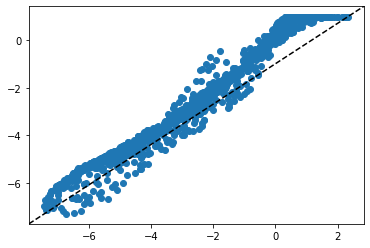

In [32]:
import matplotlib.pyplot as plt

plt.scatter(y_mean,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

In [33]:
from MFRBF import MFRBF

In [34]:
X_currin_cheap = X[0]
X_currin_expensive = X[1]

In [35]:
y_currin_cheap = Y[0]
y_currin_expensive = Y[1]

In [36]:
X_currin_cheap.shape

(12, 2)

In [37]:
X_currin_expensive.shape

(5, 2)

In [38]:
y_currin_cheap.shape

(12, 1)

In [39]:
y_currin_expensive.shape

(5, 1)

In [42]:
import GPy
from GPy.kern import Kern
from GPy import Param, Model

m4 = GPy.models.GPRegression(X_currin_cheap, y_currin_cheap)
m4.optimize()

In [43]:
print(m4)


Name : GP regression
Objective : 17.81724633476272
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    9.124108457563176  |      +ve      |        
  rbf.lengthscale          |   0.5058353079318674  |      +ve      |        
  Gaussian_noise.variance  |  0.07381134990551635  |      +ve      |        


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a5247eb38>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1a498ec630>]}

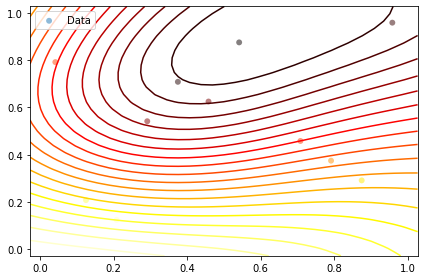

In [44]:
m4.plot()

In [45]:
mu_currin, v_currin = m4.predict(X_currin_expensive, full_cov = True)

In [46]:
kern_currin = MFRBF(input_dim=X_currin_expensive.shape[1], variance = 10, lengthscale = 1, mu = mu_currin, v=v_currin)
#k_currin_1 = deepKern.K(X_currin_expensive)

k_currin_rbf = GPy.kern.RBF(input_dim = X_currin_expensive.shape[1])

k_currin = kern_currin * k_currin_rbf

m_currin = GPy.models.GPRegression(X_currin_expensive, y_currin_expensive, k_currin)

In [47]:
m_currin.optimize()

In [48]:
print(m_currin)


Name : GP regression
Objective : 9.586729616000518
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  mul.MFRBF.variance       |      9.44959974168044  |               |        
  mul.MFRBF.lengtscale     |     8.738373674404015  |               |        
  mul.rbf.variance         |    1.9129395872826924  |      +ve      |        
  mul.rbf.lengthscale      |    1.3175014244950027  |      +ve      |        
  Gaussian_noise.variance  |  8.46778371913399e-07  |      +ve      |        


In [49]:
X_test = x_test[:,0:2]

In [50]:
X_test.shape

(1000, 2)

In [51]:
y_test.shape

(1000, 1)

In [53]:
def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, np.sqrt(pred_v)


In [54]:
s1=m_currin.kern.rbf.variance[0]
l1=m_currin.kern.rbf.lengthscale[0]
s2=m_currin.kern.MFRBF.variance[0]
l2=m_currin.kern.MFRBF.lengthscale[0]


Y_test=[]
Y_test_up=[]
Y_test_down=[]

for i in range(X_test.shape[0]):
    xx = X_test[i].reshape(1,2)
    Xnew = np.vstack((xx,X_currin_expensive))
    mu1, v1 = m4.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, y_currin_expensive)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)
    

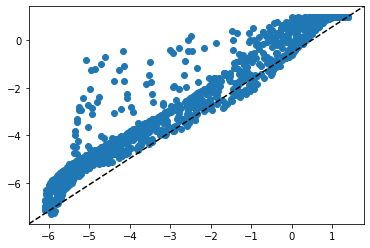

In [55]:
#print(calculate_metrics(y_test, Y_test, y_var))

plt.scatter(Y_test,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [56]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [57]:
print(rmse(Y_test,y_test))

0.6880419828071428


In [58]:
print(compute_nll(y_test,Y_test,np.array(Y_test_up)-np.array(Y_test)))

8.866381938998567


In [59]:
print(calculate_metrics(y_test, Y_test, np.array(Y_test_up)-np.array(Y_test)))

{'r2': 0.9189228023705566, 'rmse': 0.6880419828071428, 'mnll': 1.028550825279758}
